In [ ]:
!pip install catboost
!pip install pytorch-tabnet

     |████████████████████████████████| 69.2MB 43kB/s 


In [ ]:
import catboost

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
 
import pathlib
 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
 
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import stats
from tensorflow import keras
from keras import models, optimizers, regularizers
from keras.layers import Dense, Dropout
#from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping
 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import auc

from sklearn.ensemble import RandomForestClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, ShuffleSplit

import time

from pytorch_tabnet.tab_model import TabNetClassifier

import torch
 
print(tf.__version__)

2.5.0


In [ ]:
import sys
print(sys.version)

3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [ ]:
#Считывание наборов данных
raw_ar_inter = pd.read_csv('/content/drive/MyDrive/Diplom/ar_inter.txt',
                           sep="	")
raw_erg_inter = pd.read_csv('/content/drive/MyDrive/Diplom/erg_inter.txt',
                            sep="	")
raw_ar_prom = pd.read_csv('/content/drive/MyDrive/Diplom/ar_prom.txt',
                          sep="	")
raw_erg_prom = pd.read_csv('/content/drive/MyDrive/Diplom/erg_prom.txt',
                           sep="	")

In [ ]:
ar_inter = raw_ar_inter.copy()
erg_inter = raw_erg_inter.copy()
ar_prom = raw_ar_prom.copy()
erg_prom = raw_erg_prom.copy()
print(ar_inter.tail(), '\n', erg_inter.tail(), '\n', ar_prom.tail(), '\n',
      erg_prom.tail())

                             ID  ... FPEAKS000549.MACS2MLog10QValue
8709  ms.ANDR_HUMAN.12219075.v1  ...                            NaN
8710  ms.ANDR_HUMAN.12221330.v1  ...                        1.97943
8711  ms.ANDR_HUMAN.12221337.v1  ...                        2.58281
8712  ms.ANDR_HUMAN.12221346.v1  ...                            NaN
8713  ms.ANDR_HUMAN.12221361.v1  ...                            NaN

[5 rows x 307 columns] 
                            ID  ... FPEAKS000549.MACS2MLog10QValue
4204  ms.ERG_HUMAN.3502404.v1  ...                      329.10989
4205  ms.ERG_HUMAN.3502406.v1  ...                       33.88896
4206  ms.ERG_HUMAN.3502409.v1  ...                       58.55611
4207  ms.ERG_HUMAN.3502412.v1  ...                       47.82450
4208  ms.ERG_HUMAN.3502417.v1  ...                     2979.04517

[5 rows x 332 columns] 
                              ID  ... FPEAKS000549.MACS2MLog10QValue
2309  ms.ANDR_HUMAN.12195979.v1  ...                            NaN
2310  ms

In [ ]:
# Для начала заполню Nan нулями
ar_inter = ar_inter.fillna(0)
# В type заменил [yes, no] на [1, 0]
ar_inter = ar_inter.replace(['yes', 'no', 'False', 'True'], [1, 0, 0, 1])
ar_inter['Untreated'] = ar_inter['Untreated'].astype('float')


erg_inter = erg_inter.fillna(0)
erg_inter = erg_inter.replace(['yes', 'no', 'False', 'True'], [1, 0, 0, 1])
erg_inter['Untreated'] = erg_inter['Untreated'].astype('float')


ar_prom = ar_prom.fillna(0)
ar_prom = ar_prom.replace(['yes', 'no', 'False', 'True'], [1, 0, 0, 1])
ar_prom['Untreated'] = ar_prom['Untreated'].astype('float')


erg_prom = erg_prom.fillna(0)
erg_prom = erg_prom.replace(['yes', 'no', 'False', 'True'], [1, 0, 0, 1])
erg_prom['Untreated'] = erg_prom['Untreated'].astype('float')

In [ ]:
# Удалим ID, он нам не нужен
ar_inter = ar_inter.drop(ar_inter.columns[[0]], axis = 'columns')
erg_inter = erg_inter.drop(erg_inter.columns[[0]], axis = 'columns')
ar_prom = ar_prom.drop(ar_prom.columns[[0]], axis = 'columns')
erg_prom = erg_prom.drop(erg_prom.columns[[0]], axis = 'columns')

In [ ]:
#Выводит статистики для дальнейшего нормирования параметров
stats_ar_inter = ar_inter.describe().copy() 
stats_ar_inter.pop('type')
stats_ar_inter = stats_ar_inter.transpose()

stats_erg_inter = erg_inter.describe().copy() 
stats_erg_inter.pop('type')
stats_erg_inter = stats_erg_inter.transpose()

stats_ar_prom = ar_prom.describe().copy() 
stats_ar_prom.pop('type')
stats_ar_prom = stats_ar_prom.transpose()

stats_erg_prom = erg_prom.describe().copy() 
stats_erg_prom.pop('type')
stats_erg_prom = stats_erg_prom.transpose()

In [ ]:
# Функция нормирования параметров
def norm(x, i):
  # mean - средне гармоническое отклонение, 
  # std - средне квадратическое отклонение
  if i == 0:
    return (x - stats_ar_inter['mean']) / stats_ar_inter['std']
  if i == 1:
    return (x - stats_erg_inter['mean']) / stats_erg_inter['std']
  if i == 2:
    return (x - stats_ar_prom['mean']) / stats_ar_prom['std']
  if i == 3:
    return (x - stats_erg_prom['mean']) / stats_erg_prom['std']

In [ ]:
#Разделение на обучающие и тестовые выборки
Random_State = 12345
train_ar_inter = ar_inter.sample(frac = 0.8, random_state = Random_State)
test_ar_inter = ar_inter.drop(train_ar_inter.index)
train_labels_ar_inter = train_ar_inter.pop('type')
test_labels_ar_inter = test_ar_inter.pop('type')

train_erg_inter = erg_inter.sample(frac = 0.8, random_state = Random_State)
test_erg_inter = erg_inter.drop(train_erg_inter.index)
train_labels_erg_inter = train_erg_inter.pop('type')
test_labels_erg_inter = test_erg_inter.pop('type')

train_ar_prom = ar_prom.sample(frac = 0.8, random_state = Random_State)
test_ar_prom = ar_prom.drop(train_ar_prom.index)
train_labels_ar_prom = train_ar_prom.pop('type')
test_labels_ar_prom = test_ar_prom.pop('type')

train_erg_prom = erg_prom.sample(frac = 0.8, random_state = Random_State)
test_erg_prom = erg_prom.drop(train_erg_prom.index)
train_labels_erg_prom = train_erg_prom.pop('type')
test_labels_erg_prom = test_erg_prom.pop('type')

In [ ]:
# Нормируем параметры для обучения
normed_train_ar_inter = norm(train_ar_inter, 0)
normed_test_ar_inter = norm(test_ar_inter, 0)

normed_train_erg_inter = norm(train_erg_inter, 1)
normed_test_erg_inter = norm(test_erg_inter, 1)

normed_train_ar_prom = norm(train_ar_prom, 2)
normed_test_ar_prom = norm(test_ar_prom, 2)

normed_train_erg_prom = norm(train_erg_prom, 3)
normed_test_erg_prom = norm(test_erg_prom, 3)

In [ ]:
#Удалил все колонки с NaN, они появились из-за того, 
#что среднее квадратическое отклонение нулевое
normed_train_ar_inter = normed_train_ar_inter.dropna(axis='columns')
normed_test_ar_inter = normed_test_ar_inter.dropna(axis='columns')

normed_train_erg_inter = normed_train_erg_inter.dropna(axis='columns')
normed_test_erg_inter = normed_test_erg_inter.dropna(axis='columns')

normed_train_ar_prom = normed_train_ar_prom.dropna(axis='columns')
normed_test_ar_prom = normed_test_ar_prom.dropna(axis='columns')

normed_train_erg_prom = normed_train_erg_prom.dropna(axis='columns')
normed_test_erg_prom = normed_test_erg_prom.dropna(axis='columns')

In [ ]:
#Построение модели
#LReLU = tf.keras.layers.LeakyReLU(alpha=0.5)
def build_model(input_train):
  model = tf.keras.Sequential([                     
    keras.layers.Dense(2048, activation='relu', 
                       input_shape=[len(input_train.keys())], 
                       kernel_initializer='random_normal',
                       bias_initializer='random_normal'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu',),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu',),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  return model


#модель без dropout
def build_model_without_dropout(input_train):
  model_without_dropout = tf.keras.Sequential([                     
    keras.layers.Dense(64, activation='relu', 
                       input_shape=[len(input_train.keys())]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  return model_without_dropout

In [ ]:
#Задаём некоторые параметры для дальнейшего обучения моделей
model_ar_inter = build_model(normed_train_ar_inter)
model_erg_inter = build_model(normed_train_erg_inter)
model_ar_prom = build_model(normed_train_ar_prom)
model_erg_prom = build_model(normed_train_erg_prom)

EPOCHS = 200

early_stopping = keras.callbacks.EarlyStopping(patience=5)

OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.5)

METRIC = tf.keras.metrics.AUC()

In [ ]:
#Собираем модели
model_ar_inter.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=[METRIC])

model_erg_inter.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=[METRIC])

model_ar_prom.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=[METRIC])

model_erg_prom.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=[METRIC])

In [ ]:
#Обучение модели для предсказывания ar_inter
history_ar_inter = model_ar_inter.fit(normed_train_ar_inter,
                                      train_labels_ar_inter, epochs=EPOCHS,
                                      validation_split = 0.3,
                                      callbacks=[early_stopping], verbose=2)

print('\n', '\n')

#Обучение модели для предсказывания erg_inter
history_erg_inter = model_erg_inter.fit(normed_train_erg_inter,
                                        train_labels_erg_inter, epochs=EPOCHS,
                                        validation_split = 0.3,
                                        callbacks=[early_stopping], verbose=2)

print('\n', '\n')

#Обучение модели для предсказывания ar_prom
history_ar_prom = model_ar_prom.fit(normed_train_ar_prom,
                                    train_labels_ar_prom, epochs=EPOCHS,
                                    validation_split = 0.3,
                                    callbacks=[early_stopping], verbose=2)

print('\n', '\n')

#Обучение модели для предсказывания erg_prom
history_erg_prom = model_erg_prom.fit(normed_train_erg_prom,
                                      train_labels_erg_prom, epochs=EPOCHS,
                                      validation_split = 0.3,
                                      callbacks=[early_stopping], verbose=2)

print('\n', '\n')

Epoch 1/200
153/153 - 5s - loss: 0.5608 - auc: 0.4753 - val_loss: 0.4454 - val_auc: 0.7392
Epoch 2/200
153/153 - 1s - loss: 0.4601 - auc: 0.6198 - val_loss: 0.3756 - val_auc: 0.7969
Epoch 3/200
153/153 - 1s - loss: 0.4102 - auc: 0.6938 - val_loss: 0.3436 - val_auc: 0.8139
Epoch 4/200
153/153 - 1s - loss: 0.3671 - auc: 0.7406 - val_loss: 0.3400 - val_auc: 0.8318
Epoch 5/200
153/153 - 1s - loss: 0.3528 - auc: 0.7689 - val_loss: 0.3257 - val_auc: 0.8363
Epoch 6/200
153/153 - 1s - loss: 0.3336 - auc: 0.7741 - val_loss: 0.3182 - val_auc: 0.8404
Epoch 7/200
153/153 - 1s - loss: 0.3316 - auc: 0.7888 - val_loss: 0.3120 - val_auc: 0.8453
Epoch 8/200
153/153 - 1s - loss: 0.3304 - auc: 0.7914 - val_loss: 0.3137 - val_auc: 0.8495
Epoch 9/200
153/153 - 1s - loss: 0.3153 - auc: 0.8033 - val_loss: 0.3102 - val_auc: 0.8514
Epoch 10/200
153/153 - 1s - loss: 0.3094 - auc: 0.8128 - val_loss: 0.3065 - val_auc: 0.8530
Epoch 11/200
153/153 - 1s - loss: 0.3086 - auc: 0.8156 - val_loss: 0.3024 - val_auc: 0.85

In [ ]:
#Получаем точность на тестовых данных
test_loss_ar_inter, test_acc_ar_inter = model_ar_inter.evaluate(normed_test_ar_inter,
                                                                test_labels_ar_inter,
                                                                verbose=2)

test_loss_erg_inter, test_acc_erg_inter = model_erg_inter.evaluate(normed_test_erg_inter,
                                                                   test_labels_erg_inter,
                                                                   verbose=2)

test_loss_ar_prom, test_acc_ar_prom = model_ar_prom.evaluate(normed_test_ar_prom,
                                                             test_labels_ar_prom,
                                                             verbose=2)

test_loss_erg_prom, test_acc_erg_prom = model_erg_prom.evaluate(normed_test_erg_prom,
                                                                test_labels_erg_prom,
                                                                verbose=2)

55/55 - 0s - loss: 0.2855 - auc: 0.8531
27/27 - 0s - loss: 0.1642 - auc: 0.9818
15/15 - 0s - loss: 0.6667 - auc: 0.6211
151/151 - 0s - loss: 0.2729 - auc: 0.6041


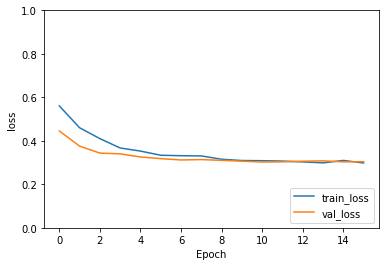

In [ ]:
plt.plot(history_ar_inter.history['loss'], label='train_loss')
plt.plot(history_ar_inter.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

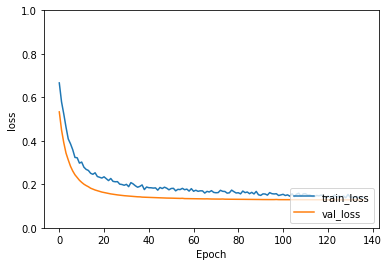

In [ ]:
plt.plot(history_erg_inter.history['loss'], label='train_loss')
plt.plot(history_erg_inter.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

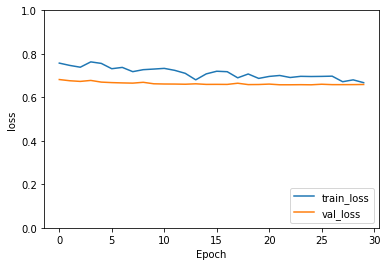

In [ ]:
plt.plot(history_ar_prom.history['loss'], label='train_loss')
plt.plot(history_ar_prom.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

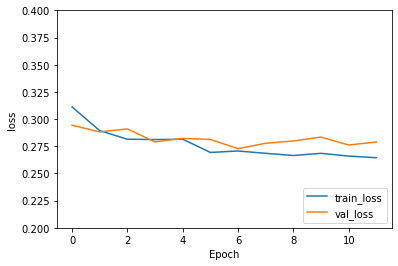

In [ ]:
plt.plot(history_erg_prom.history['loss'], label='train_loss')
plt.plot(history_erg_prom.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.2, 0.4])
plt.legend(loc='lower right')

In [ ]:
#Обучаем random forest и собираем данные для построения roc кривой
rf_ar_inter = RandomForestClassifier(n_estimators=100)
rf_erg_inter = RandomForestClassifier(n_estimators=100)
rf_ar_prom = RandomForestClassifier(n_estimators=100)
rf_erg_prom = RandomForestClassifier(n_estimators=100)

rf_ar_inter.fit(normed_train_ar_inter, train_labels_ar_inter)
rf_erg_inter.fit(normed_train_erg_inter, train_labels_erg_inter)
rf_ar_prom.fit(normed_train_ar_prom, train_labels_ar_prom)
rf_erg_prom.fit(normed_train_erg_prom, train_labels_erg_prom)

y_pred_rf_ar_inter = rf_ar_inter.predict_proba(normed_test_ar_inter)[:, 1]
y_pred_rf_erg_inter = rf_erg_inter.predict_proba(normed_test_erg_inter)[:, 1]
y_pred_rf_ar_prom = rf_ar_prom.predict_proba(normed_test_ar_prom)[:, 1]
y_pred_rf_erg_prom = rf_erg_prom.predict_proba(normed_test_erg_prom)[:, 1]

fpr_rf_ar_inter, tpr_rf_ar_inter, thresholds_rf_ar_inter = roc_curve(test_labels_ar_inter, y_pred_rf_ar_inter)
fpr_rf_erg_inter, tpr_rf_erg_inter, thresholds_rf_erg_inter = roc_curve(test_labels_erg_inter, y_pred_rf_erg_inter)
fpr_rf_ar_prom, tpr_rf_ar_prom, thresholds_rf_ar_prom = roc_curve(test_labels_ar_prom, y_pred_rf_ar_prom)
fpr_rf_erg_prom, tpr_rf_erg_prom, thresholds_rf_erg_prom = roc_curve(test_labels_erg_prom, y_pred_rf_erg_prom)

auc_rf_ar_inter = auc(fpr_rf_ar_inter, tpr_rf_ar_inter)
auc_rf_erg_inter = auc(fpr_rf_erg_inter, tpr_rf_erg_inter)
auc_rf_ar_prom = auc(fpr_rf_ar_prom, tpr_rf_ar_prom)
auc_rf_erg_prom = auc(fpr_rf_erg_prom, tpr_rf_erg_prom)

In [ ]:
#Собираем данные для roc кривой для нейронной сети
y_pred_keras_ar_inter = model_ar_inter.predict(normed_test_ar_inter).ravel()
y_pred_keras_erg_inter = model_erg_inter.predict(normed_test_erg_inter).ravel()
y_pred_keras_ar_prom = model_ar_prom.predict(normed_test_ar_prom).ravel()
y_pred_keras_erg_prom = model_erg_prom.predict(normed_test_erg_prom).ravel()

fpr_keras_ar_inter, tpr_keras_ar_inter, thresholds_keras_ar_inter = roc_curve(test_labels_ar_inter, y_pred_keras_ar_inter)
fpr_keras_erg_inter, tpr_keras_erg_inter, thresholds_keras_erg_inter = roc_curve(test_labels_erg_inter, y_pred_keras_erg_inter)
fpr_keras_ar_prom, tpr_keras_ar_prom, thresholds_keras_ar_prom = roc_curve(test_labels_ar_prom, y_pred_keras_ar_prom)
fpr_keras_erg_prom, tpr_keras_erg_prom, thresholds_keras_erg_prom = roc_curve(test_labels_erg_prom, y_pred_keras_erg_prom)

In [ ]:
auc_keras_ar_inter = auc(fpr_keras_ar_inter, tpr_keras_ar_inter)
auc_keras_erg_inter = auc(fpr_keras_erg_inter, tpr_keras_erg_inter)
auc_keras_ar_prom = auc(fpr_keras_ar_prom, tpr_keras_ar_prom)
auc_keras_erg_prom = auc(fpr_keras_erg_prom, tpr_keras_erg_prom)

In [ ]:
#Вводим модели catboost
CatBoost_ar_inter = catboost.CatBoostClassifier(num_trees = 1000)
CatBoost_erg_inter = catboost.CatBoostClassifier(num_trees = 1000)
CatBoost_ar_prom = catboost.CatBoostClassifier(num_trees = 1000)
CatBoost_erg_prom = catboost.CatBoostClassifier(num_trees = 1000)

In [ ]:
#Обучаем модели catboost
CatBoost_ar_inter.fit(normed_train_ar_inter, train_labels_ar_inter)
CatBoost_erg_inter.fit(normed_train_erg_inter, train_labels_erg_inter)
CatBoost_ar_prom.fit(normed_train_ar_prom, train_labels_ar_prom)
CatBoost_erg_prom.fit(normed_train_erg_prom, train_labels_erg_prom)

Learning rate set to 0.023606
0:	learn: 0.6697794	total: 108ms	remaining: 1m 47s
1:	learn: 0.6473571	total: 164ms	remaining: 1m 22s
2:	learn: 0.6266548	total: 217ms	remaining: 1m 12s
3:	learn: 0.6056184	total: 266ms	remaining: 1m 6s
4:	learn: 0.5880369	total: 315ms	remaining: 1m 2s
5:	learn: 0.5711631	total: 365ms	remaining: 1m
6:	learn: 0.5540866	total: 428ms	remaining: 1m
7:	learn: 0.5379601	total: 481ms	remaining: 59.6s
8:	learn: 0.5228394	total: 533ms	remaining: 58.6s
9:	learn: 0.5083842	total: 595ms	remaining: 58.9s
10:	learn: 0.4955022	total: 647ms	remaining: 58.2s
11:	learn: 0.4830103	total: 697ms	remaining: 57.3s
12:	learn: 0.4708608	total: 746ms	remaining: 56.7s
13:	learn: 0.4596009	total: 796ms	remaining: 56s
14:	learn: 0.4494858	total: 859ms	remaining: 56.4s
15:	learn: 0.4392187	total: 911ms	remaining: 56s
16:	learn: 0.4306013	total: 960ms	remaining: 55.5s
17:	learn: 0.4215103	total: 1.02s	remaining: 55.9s
18:	learn: 0.4133889	total: 1.08s	remaining: 55.8s
19:	learn: 0.40505

In [ ]:
#Собираем данные для roc кривой для catboost
y_pred_catboost_ar_inter = CatBoost_ar_inter.predict(normed_test_ar_inter, prediction_type='Probability')[:, 1].ravel()
fpr_catboost_ar_inter, tpr_catboost_ar_inter, thresholds_catboost_ar_inter = roc_curve(test_labels_ar_inter, y_pred_catboost_ar_inter)
auc_catboost_ar_inter = auc(fpr_catboost_ar_inter, tpr_catboost_ar_inter)

y_pred_catboost_erg_inter = CatBoost_erg_inter.predict(normed_test_erg_inter, prediction_type='Probability')[:, 1].ravel()
fpr_catboost_erg_inter, tpr_catboost_erg_inter, thresholds_catboost_erg_inter = roc_curve(test_labels_erg_inter, y_pred_catboost_erg_inter)
auc_catboost_erg_inter = auc(fpr_catboost_erg_inter, tpr_catboost_erg_inter)

y_pred_catboost_ar_prom = CatBoost_ar_prom.predict(normed_test_ar_prom, prediction_type='Probability')[:, 1].ravel()
fpr_catboost_ar_prom, tpr_catboost_ar_prom, thresholds_catboost_ar_prom = roc_curve(test_labels_ar_prom, y_pred_catboost_ar_prom)
auc_catboost_ar_prom = auc(fpr_catboost_ar_prom, tpr_catboost_ar_prom)

y_pred_catboost_erg_prom = CatBoost_erg_prom.predict(normed_test_erg_prom, prediction_type='Probability')[:, 1].ravel()
fpr_catboost_erg_prom, tpr_catboost_erg_prom, thresholds_catboost_erg_prom = roc_curve(test_labels_erg_prom, y_pred_catboost_erg_prom)
auc_catboost_erg_prom = auc(fpr_catboost_erg_prom, tpr_catboost_erg_prom)

In [ ]:
#Вводим tabnet модели
tabnet_ar_inter = TabNetClassifier()
tabnet_erg_inter = TabNetClassifier()
tabnet_ar_prom = TabNetClassifier()
tabnet_erg_prom = TabNetClassifier()

Device used : cuda
Device used : cuda
Device used : cuda
Device used : cuda


In [ ]:
#Разделяю train на train и val, потому что tabnet не делает это сам
#Не придумал как сделать это по-человечески, поэтому прописал всё с нуля
ar_inter = raw_ar_inter.copy()
erg_inter = raw_erg_inter.copy()
ar_prom = raw_ar_prom.copy()
erg_prom = raw_erg_prom.copy()

ar_inter = ar_inter.fillna(0)
ar_inter = ar_inter.replace(['yes', 'no', 'False', 'True'], [1, 0, 0, 1])
ar_inter['Untreated'] = ar_inter['Untreated'].astype('float')
erg_inter = erg_inter.fillna(0)
erg_inter = erg_inter.replace(['yes', 'no', 'False', 'True'], [1, 0, 0, 1])
erg_inter['Untreated'] = erg_inter['Untreated'].astype('float')
ar_prom = ar_prom.fillna(0)
ar_prom = ar_prom.replace(['yes', 'no', 'False', 'True'], [1, 0, 0, 1])
ar_prom['Untreated'] = ar_prom['Untreated'].astype('float')
erg_prom = erg_prom.fillna(0)
erg_prom = erg_prom.replace(['yes', 'no', 'False', 'True'], [1, 0, 0, 1])
erg_prom['Untreated'] = erg_prom['Untreated'].astype('float')

ar_inter = ar_inter.drop(ar_inter.columns[[0]], axis = 'columns')
erg_inter = erg_inter.drop(erg_inter.columns[[0]], axis = 'columns')
ar_prom = ar_prom.drop(ar_prom.columns[[0]], axis = 'columns')
erg_prom = erg_prom.drop(erg_prom.columns[[0]], axis = 'columns')

Random_State = 12345
train_ar_inter = ar_inter.sample(frac = 0.8, random_state = Random_State)
test_ar_inter = ar_inter.drop(train_ar_inter.index)
val_ar_inter = train_ar_inter.sample(frac = 0.3, random_state = Random_State)
train_ar_inter = train_ar_inter.drop(val_ar_inter.index)
train_labels_ar_inter = train_ar_inter.pop('type')
test_labels_ar_inter = test_ar_inter.pop('type')
val_labels_ar_inter = val_ar_inter.pop('type')

train_erg_inter = erg_inter.sample(frac = 0.8, random_state = Random_State)
test_erg_inter = erg_inter.drop(train_erg_inter.index)
val_erg_inter = train_erg_inter.sample(frac = 0.3, random_state = Random_State)
train_erg_inter = train_erg_inter.drop(val_erg_inter.index)
train_labels_erg_inter = train_erg_inter.pop('type')
test_labels_erg_inter = test_erg_inter.pop('type')
val_labels_erg_inter = val_erg_inter.pop('type')

train_ar_prom = ar_prom.sample(frac = 0.8, random_state = Random_State)
test_ar_prom = ar_prom.drop(train_ar_prom.index)
val_ar_prom = train_ar_prom.sample(frac = 0.3, random_state = Random_State)
train_ar_prom = train_ar_prom.drop(val_ar_prom.index)
train_labels_ar_prom = train_ar_prom.pop('type')
test_labels_ar_prom = test_ar_prom.pop('type')
val_labels_ar_prom = val_ar_prom.pop('type')

train_erg_prom = erg_prom.sample(frac = 0.8, random_state = Random_State)
test_erg_prom = erg_prom.drop(train_erg_prom.index)
val_erg_prom = train_erg_prom.sample(frac = 0.3, random_state = Random_State)
train_erg_prom = train_erg_prom.drop(val_erg_prom.index)
train_labels_erg_prom = train_erg_prom.pop('type')
test_labels_erg_prom = test_erg_prom.pop('type')
val_labels_erg_prom = val_erg_prom.pop('type')

normed_train_ar_inter = norm(train_ar_inter, 0)
normed_test_ar_inter = norm(test_ar_inter, 0)
normed_val_ar_inter = norm(val_ar_inter, 0)

normed_train_erg_inter = norm(train_erg_inter, 1)
normed_test_erg_inter = norm(test_erg_inter, 1)
normed_val_erg_inter = norm(val_erg_inter, 1)

normed_train_ar_prom = norm(train_ar_prom, 2)
normed_test_ar_prom = norm(test_ar_prom, 2)
normed_val_ar_prom = norm(val_ar_prom, 2)

normed_train_erg_prom = norm(train_erg_prom, 3)
normed_test_erg_prom = norm(test_erg_prom, 3)
normed_val_erg_prom = norm(val_erg_prom, 3)

normed_train_ar_inter = normed_train_ar_inter.dropna(axis='columns')
normed_test_ar_inter = normed_test_ar_inter.dropna(axis='columns')
normed_val_ar_inter = normed_val_ar_inter.dropna(axis='columns')

normed_train_erg_inter = normed_train_erg_inter.dropna(axis='columns')
normed_test_erg_inter = normed_test_erg_inter.dropna(axis='columns')
normed_val_erg_inter = normed_val_erg_inter.dropna(axis='columns')

normed_train_ar_prom = normed_train_ar_prom.dropna(axis='columns')
normed_test_ar_prom = normed_test_ar_prom.dropna(axis='columns')
normed_val_ar_prom = normed_val_ar_prom.dropna(axis='columns')

normed_train_erg_prom = normed_train_erg_prom.dropna(axis='columns')
normed_test_erg_prom = normed_test_erg_prom.dropna(axis='columns')
normed_val_erg_prom = normed_val_erg_prom.dropna(axis='columns')

In [ ]:
train_ar_inter = np.array(normed_train_ar_inter)
test_ar_inter = np.array(normed_test_ar_inter)
val_ar_inter = np.array(normed_val_ar_inter)

train_erg_inter = np.array(normed_train_erg_inter)
test_erg_inter = np.array(normed_test_erg_inter)
val_erg_inter = np.array(normed_val_erg_inter)

train_ar_prom = np.array(normed_train_ar_prom)
test_ar_prom = np.array(normed_test_ar_prom)
val_ar_prom = np.array(normed_val_ar_prom)

train_erg_prom = np.array(normed_train_erg_prom)
test_erg_prom = np.array(normed_test_erg_prom)
val_erg_prom = np.array(normed_val_erg_prom)

In [ ]:
tabnet_ar_inter.fit(train_ar_inter, train_labels_ar_inter,
          eval_set=[(train_ar_inter, train_labels_ar_inter),
                    (val_ar_inter, val_labels_ar_inter)],
                    eval_metric = ['auc'])

tabnet_erg_inter.fit(train_erg_inter, train_labels_erg_inter,
          eval_set=[(train_erg_inter, train_labels_erg_inter),
                    (val_erg_inter, val_labels_erg_inter)],
                     eval_metric = ['auc'])

tabnet_ar_prom.fit(train_ar_prom, train_labels_ar_prom,
          eval_set=[(train_ar_prom, train_labels_ar_prom),
                    (val_ar_prom, val_labels_ar_prom)],
                    eval_metric = ['auc'])

tabnet_erg_prom.fit(train_erg_prom, train_labels_erg_prom,
          eval_set=[(train_erg_prom, train_labels_erg_prom),
                    (val_erg_prom, val_labels_erg_prom)],
                    eval_metric = ['auc'])

epoch 0  | loss: 0.62345 | val_0_auc: 0.50007 | val_1_auc: 0.51924 |  0:00:00s
epoch 1  | loss: 0.51874 | val_0_auc: 0.60434 | val_1_auc: 0.61004 |  0:00:01s
epoch 2  | loss: 0.46112 | val_0_auc: 0.72039 | val_1_auc: 0.71438 |  0:00:01s
epoch 3  | loss: 0.41903 | val_0_auc: 0.8015  | val_1_auc: 0.80036 |  0:00:01s
epoch 4  | loss: 0.38067 | val_0_auc: 0.83853 | val_1_auc: 0.82676 |  0:00:02s
epoch 5  | loss: 0.3551  | val_0_auc: 0.8406  | val_1_auc: 0.82884 |  0:00:02s
epoch 6  | loss: 0.33875 | val_0_auc: 0.83678 | val_1_auc: 0.83435 |  0:00:02s
epoch 7  | loss: 0.33146 | val_0_auc: 0.84168 | val_1_auc: 0.8406  |  0:00:03s
epoch 8  | loss: 0.3224  | val_0_auc: 0.84642 | val_1_auc: 0.8484  |  0:00:03s
epoch 9  | loss: 0.31482 | val_0_auc: 0.84563 | val_1_auc: 0.84763 |  0:00:04s
epoch 10 | loss: 0.30776 | val_0_auc: 0.85097 | val_1_auc: 0.84976 |  0:00:04s
epoch 11 | loss: 0.31406 | val_0_auc: 0.85007 | val_1_auc: 0.84552 |  0:00:04s
epoch 12 | loss: 0.31212 | val_0_auc: 0.85013 | val_

In [ ]:
y_pred_tabnet_ar_inter = tabnet_ar_inter.predict_proba(test_ar_inter)[:, 1]

y_pred_tabnet_erg_inter = tabnet_erg_inter.predict_proba(test_erg_inter)[:, 1]

y_pred_tabnet_ar_prom = tabnet_ar_prom.predict_proba(test_ar_prom)[:, 1]

y_pred_tabnet_erg_prom = tabnet_erg_prom.predict_proba(test_erg_prom)[:, 1]

In [ ]:
fpr_tabnet_ar_inter, tpr_tabnet_ar_inter, thresholds_tabnet_ar_inter = roc_curve(test_labels_ar_inter, y_pred_tabnet_ar_inter)
auc_tabnet_ar_inter = auc(fpr_tabnet_ar_inter, tpr_tabnet_ar_inter)

fpr_tabnet_erg_inter, tpr_tabnet_erg_inter, thresholds_tabnet_erg_inter = roc_curve(test_labels_erg_inter, y_pred_tabnet_erg_inter)
auc_tabnet_erg_inter = auc(fpr_tabnet_erg_inter, tpr_tabnet_erg_inter)

fpr_tabnet_ar_prom, tpr_tabnet_ar_prom, thresholds_tabnet_ar_prom = roc_curve(test_labels_ar_prom, y_pred_tabnet_ar_prom)
auc_tabnet_ar_prom = auc(fpr_tabnet_ar_prom, tpr_tabnet_ar_prom)

fpr_tabnet_erg_prom, tpr_tabnet_erg_prom, thresholds_tabnet_erg_prom = roc_curve(test_labels_erg_prom, y_pred_tabnet_erg_prom)
auc_tabnet_erg_prom = auc(fpr_tabnet_erg_prom, tpr_tabnet_erg_prom)

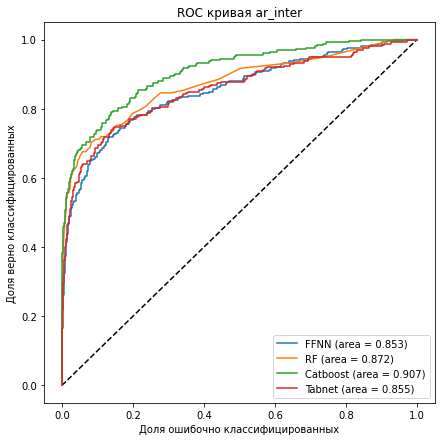

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_ar_inter, tpr_keras_ar_inter,
         label='FFNN (area = {:.3f})'.format(auc_keras_ar_inter))
plt.plot(fpr_rf_ar_inter, tpr_rf_ar_inter,
         label='RF (area = {:.3f})'.format(auc_rf_ar_inter))
plt.plot(fpr_catboost_ar_inter, tpr_catboost_ar_inter,
         label='Catboost (area = {:.3f})'.format(auc_catboost_ar_inter))
plt.plot(fpr_tabnet_ar_inter, tpr_tabnet_ar_inter,
         label='Tabnet (area = {:.3f})'.format(auc_tabnet_ar_inter))
plt.xlabel('Доля ошибочно классифицированных')
plt.ylabel('Доля верно классифицированных')
plt.title('ROC кривая ar_inter')
plt.legend(loc='best')
plt.savefig('/content/drive/My Drive/ar_inter.png')
plt.show()

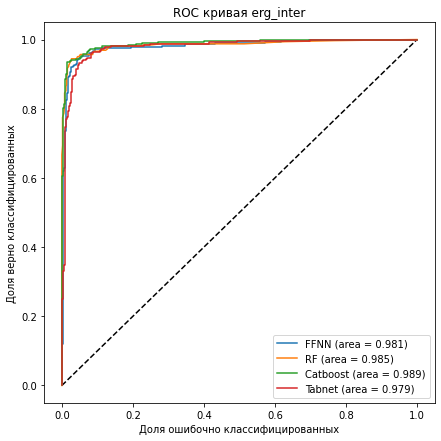

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_erg_inter, tpr_keras_erg_inter,
         label='FFNN (area = {:.3f})'.format(auc_keras_erg_inter))
plt.plot(fpr_rf_erg_inter, tpr_rf_erg_inter,
         label='RF (area = {:.3f})'.format(auc_rf_erg_inter))
plt.plot(fpr_catboost_erg_inter, tpr_catboost_erg_inter,
         label='Catboost (area = {:.3f})'.format(auc_catboost_erg_inter))
plt.plot(fpr_tabnet_erg_inter, tpr_tabnet_erg_inter,
         label='Tabnet (area = {:.3f})'.format(auc_tabnet_erg_inter))
plt.xlabel('Доля ошибочно классифицированных')
plt.ylabel('Доля верно классифицированных')
plt.title('ROC кривая erg_inter')
plt.legend(loc='best')
plt.savefig('/content/drive/My Drive/erg_inter.png')
plt.show()

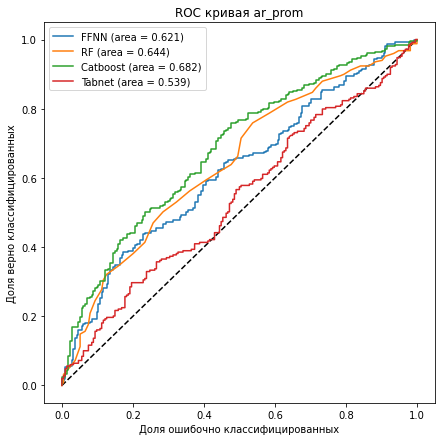

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_ar_prom, tpr_keras_ar_prom,
         label='FFNN (area = {:.3f})'.format(auc_keras_ar_prom))
plt.plot(fpr_rf_ar_prom, tpr_rf_ar_prom,
         label='RF (area = {:.3f})'.format(auc_rf_ar_prom))
plt.plot(fpr_catboost_ar_prom, tpr_catboost_ar_prom,
         label='Catboost (area = {:.3f})'.format(auc_catboost_ar_prom))
plt.plot(fpr_tabnet_ar_prom, tpr_tabnet_ar_prom,
         label='Tabnet (area = {:.3f})'.format(auc_tabnet_ar_prom))
plt.xlabel('Доля ошибочно классифицированных')
plt.ylabel('Доля верно классифицированных')
plt.title('ROC кривая ar_prom')
plt.legend(loc='best')
plt.savefig('/content/drive/My Drive/ar_prom.png')
plt.show()

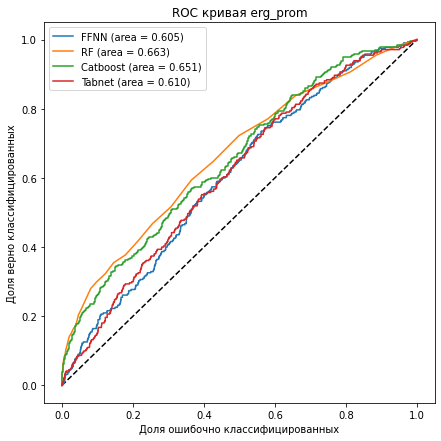

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_erg_prom, tpr_keras_erg_prom,
         label='FFNN (area = {:.3f})'.format(auc_keras_erg_prom))
plt.plot(fpr_rf_erg_prom, tpr_rf_erg_prom,
         label='RF (area = {:.3f})'.format(auc_rf_erg_prom))
plt.plot(fpr_catboost_erg_prom, tpr_catboost_erg_prom,
         label='Catboost (area = {:.3f})'.format(auc_catboost_erg_prom))
plt.plot(fpr_tabnet_erg_prom, tpr_tabnet_erg_prom,
         label='Tabnet (area = {:.3f})'.format(auc_tabnet_erg_prom))
plt.xlabel('Доля ошибочно классифицированных')
plt.ylabel('Доля верно классифицированных')
plt.title('ROC кривая erg_prom')
plt.legend(loc='best')
plt.savefig('/content/drive/My Drive/erg_prom.png')
plt.show()

In [ ]:
# Собираю признаки и считаю их важность, соединяю в датафрейм и сортирую 
# по убыванию
ar_inter_features = normed_train_ar_inter.columns.tolist()
erg_inter_features = normed_train_erg_inter.columns.tolist()
ar_prom_features = normed_train_ar_prom.columns.tolist()
erg_prom_features = normed_train_erg_prom.columns.tolist()

ar_inter_importance_Cat = CatBoost_ar_inter.get_feature_importance()
erg_inter_importance_Cat = CatBoost_erg_inter.get_feature_importance()
ar_prom_importance_Cat = CatBoost_ar_prom.get_feature_importance()
erg_prom_importance_Cat = CatBoost_erg_prom.get_feature_importance()

ar_inter_importance = pd.DataFrame({'features' : ar_inter_features,
                                    'importance' : ar_inter_importance_Cat})
erg_inter_importance = pd.DataFrame({'features' : erg_inter_features,
                                    'importance' : erg_inter_importance_Cat})
ar_prom_importance = pd.DataFrame({'features' : ar_prom_features,
                                    'importance' : ar_prom_importance_Cat})
erg_prom_importance = pd.DataFrame({'features' : erg_prom_features,
                                    'importance' : erg_prom_importance_Cat})

ar_inter_importance = ar_inter_importance.sort_values('importance',
                                                      ascending=False)
erg_inter_importance = erg_inter_importance.sort_values('importance',
                                                        ascending=False)
ar_prom_importance = ar_prom_importance.sort_values('importance',
                                                    ascending=False)
erg_prom_importance = erg_prom_importance.sort_values('importance',
                                                      ascending=False)

In [ ]:
print('ar_inter', '\n', ar_inter_importance.head(20))
print('erg_inter', '\n', erg_inter_importance.head(20))
print('ar_prom', '\n', ar_prom_importance.head(20))
print('erg_prom', '\n', erg_prom_importance.head(20))

ar_inter 
                                      features  importance
213  HPEAKS001359_H3K27ac.MACS2FoldEnrichment    7.145812
214    HPEAKS001359_H3K27ac.MACS2MLog10PValue    5.627056
215    HPEAKS001359_H3K27ac.MACS2MLog10QValue    5.348253
212               HPEAKS001359_H3K27ac.Pileup    4.659169
236               HPEAKS012136_H3K4me3.Pileup    3.252605
117                 GCR_HUMAN.ClosestDistance    2.693821
173               RUNX1_HUMAN.ClosestDistance    2.450802
80                FOXP1_HUMAN.ClosestDistance    2.302518
56                 ESR1_HUMAN.ClosestDistance    1.982847
127                  GCR_HUMAN.HOCOMOCO_SCORE    1.525315
252               HPEAKS012146_H3K4me2.Pileup    1.306604
257   HPEAKS012171_H2AZac.MACS2FoldEnrichment    1.238530
256                HPEAKS012171_H2AZac.Pileup    1.179227
155                     MBL2_HUMAN.gemQMLog10    1.178616
258     HPEAKS012171_H2AZac.MACS2MLog10PValue    1.120140
151                MBL2_HUMAN.ClosestDistance    1.105962
18 

In [ ]:
# Строю векторы предсказаний для тестовых выборок

pred_NN_ar_inter = model_ar_inter.predict(normed_test_ar_inter).argmax(axis=-1)
pred_NN_erg_inter = model_erg_inter.predict(normed_test_erg_inter).argmax(axis=-1)
pred_NN_ar_prom = model_ar_prom.predict(normed_test_ar_prom).argmax(axis=-1)
pred_NN_erg_prom = model_erg_prom.predict(normed_test_erg_prom).argmax(axis=-1)

pred_catboost_ar_inter = CatBoost_ar_inter.predict(normed_test_ar_inter, prediction_type='Class')
pred_catboost_erg_inter = CatBoost_erg_inter.predict(normed_test_erg_inter, prediction_type='Class')
pred_catboost_ar_prom = CatBoost_ar_prom.predict(normed_test_ar_prom, prediction_type='Class')
pred_catboost_erg_prom = CatBoost_erg_prom.predict(normed_test_erg_prom, prediction_type='Class')

pred_tabnet_ar_inter = tabnet_ar_inter.predict(test_ar_inter)
pred_tabnet_erg_inter = tabnet_erg_inter.predict(test_erg_inter)
pred_tabnet_ar_prom = tabnet_ar_prom.predict(test_ar_prom)
pred_tabnet_erg_prom = tabnet_erg_prom.predict(test_erg_prom)

pred_rf_ar_inter = rf_ar_inter.predict(normed_test_ar_inter)
pred_rf_erg_inter = rf_erg_inter.predict(normed_test_erg_inter)
pred_rf_ar_prom = rf_ar_prom.predict(normed_test_ar_prom)
pred_rf_erg_prom = rf_erg_prom.predict(normed_test_erg_prom)

pred_tabnet_ar_prom

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [ ]:
ar_inter_frame = pd.DataFrame({'preds NN': pred_NN_ar_inter, 
                               'preds Cat': pred_catboost_ar_inter,
                               'preds Tabnet': pred_tabnet_ar_inter,
                               'preds RF': pred_rf_ar_inter,
                               'labels': test_labels_ar_inter})
erg_inter_frame = pd.DataFrame({'preds NN': pred_NN_erg_inter,
                                'preds Cat': pred_catboost_erg_inter,
                                'preds Tabnet': pred_tabnet_erg_inter,
                                'preds RF': pred_rf_erg_inter,
                                'labels': test_labels_erg_inter})
ar_prom_frame = pd.DataFrame({'preds NN': pred_NN_ar_prom,
                              'preds Cat': pred_catboost_ar_prom,
                              'preds Tabnet': pred_tabnet_ar_prom,
                              'preds RF': pred_rf_ar_prom,
                              'labels': test_labels_ar_prom})
erg_prom_frame = pd.DataFrame({'preds NN': pred_NN_erg_prom,
                               'preds Cat': pred_catboost_erg_prom,
                               'preds Tabnet': pred_tabnet_erg_prom,
                               'preds RF': pred_rf_erg_prom,
                               'labels': test_labels_erg_prom})

In [ ]:
ar_inter_corr = ar_inter_frame.corr()
erg_inter_corr = erg_inter_frame.corr()
ar_prom_corr = ar_prom_frame.corr()
erg_prom_corr = erg_prom_frame.corr()

In [ ]:
print(ar_inter_corr, '\n', erg_inter_corr, '\n', ar_prom_corr, '\n', erg_prom_corr)

              preds NN  preds Cat  preds Tabnet  preds RF    labels
preds NN      1.000000   0.908935      0.880628  0.921412  0.618538
preds Cat     0.908935   1.000000      0.903717  0.953577  0.706345
preds Tabnet  0.880628   0.903717      1.000000  0.913446  0.635052
preds RF      0.921412   0.953577      0.913446  1.000000  0.675939
labels        0.618538   0.706345      0.635052  0.675939  1.000000 
               preds NN  preds Cat  preds Tabnet  preds RF    labels
preds NN      1.000000   0.975649      0.958089  0.972441  0.912116
preds Cat     0.975649   1.000000      0.969539  0.987673  0.929114
preds Tabnet  0.958089   0.969539      1.000000  0.971686  0.896333
preds RF      0.972441   0.987673      0.971686  1.000000  0.919706
labels        0.912116   0.929114      0.896333  0.919706  1.000000 
               preds NN  preds Cat  preds Tabnet  preds RF    labels
preds NN      1.000000   0.625453      0.315719  0.475720  0.220117
preds Cat     0.625453   1.000000      0.174

In [ ]:
import sklearn
from sklearn import metrics

In [ ]:
test_labels_erg_prom

4        1
7        1
17       1
19       1
21       1
        ..
24020    0
24030    0
24036    0
24038    0
24054    0
Name: type, Length: 4814, dtype: int64

In [ ]:
ar_inter_frame = pd.DataFrame({'preds NN': pred_NN_ar_inter, 
                               'preds Cat': pred_catboost_ar_inter,
                               'preds Tabnet': pred_tabnet_ar_inter,
                               'preds RF': pred_rf_ar_inter,
                               'labels': test_labels_ar_inter})
erg_inter_frame = pd.DataFrame({'preds NN': pred_NN_erg_inter,
                                'preds Cat': pred_catboost_erg_inter,
                                'preds Tabnet': pred_tabnet_erg_inter,
                                'preds RF': pred_rf_erg_inter,
                                'labels': test_labels_erg_inter})
ar_prom_frame = pd.DataFrame({'preds NN': pred_NN_ar_prom,
                              'preds Cat': pred_catboost_ar_prom,
                              'preds Tabnet': pred_tabnet_ar_prom,
                              'preds RF': pred_rf_ar_prom,
                              'labels': test_labels_ar_prom})
erg_prom_frame = pd.DataFrame({'preds NN': pred_NN_erg_prom,
                               'preds Cat': pred_catboost_erg_prom,
                               'preds Tabnet': pred_tabnet_erg_prom,
                               'preds RF': pred_rf_erg_prom,
                               'labels': test_labels_erg_prom})

In [ ]:
min(y_pred_tabnet_ar_prom)

0.25333136

In [ ]:
sklearn.metrics.f1_score(test_labels_ar_prom, pred_tabnet_ar_prom)

0.6914285714285714